# Figuras com Inventário Local d04

In [1]:
import numpy as np
from netCDF4 import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
import xarray as xr
import seaborn as sns
%matplotlib inline

In [2]:
directory = str('D:/Mestrado/1.Resultados/Emissoes/')
metdir = str('D:/Mestrado/1.Resultados/Meteorologia/')
grade = ['d01_27km','d02_9km','d03_3km','d04_1km']
wrfmodel = 'rizzieri2016_nudge'
emimodel = 'COMBO'
shapes = ['pirashape','RMSP']

## Abrir Inventário de Emissões

In [3]:
inv = pd.read_csv(directory+'inventory/ptinv_pira2015_orl_v4.txt', sep=';')
inv.drop(index=np.arange(0,6,1), inplace=True)
inv = inv['#ORLPOINT'].str.split(',', expand=True)
col = ['costty','plant_id','point_id','stack_id',
       'segment','plant','scc','erptype','srctype',
       'stkhgt','stkdiam','stktemp','stkflow','stkvel',
       'sic','mact','naics','ctype','xloc','yloc','utmz',
       'cas','ann_emis','avd_emis','ceff','reff','cpri',
       'csec','nei_unique_id','oris_facility_code','oris_boiler_id',
       'ipm_yn','data_source','stack_default_flag','location_default_flag',
       'year','tribal_code','horizontal_area_fugitive','release_height_fugitive',
       'zipcode']
inv.columns=col
inv.replace(to_replace='', value=np.nan, inplace=True)
inv.dropna(axis='columns',how='all', inplace=True)
inv.set_index(['plant','cas', 'stack_id'], inplace=True)
strcolumns = ['ann_emis','stkhgt','stkdiam', 'stkvel', 'xloc', 'yloc']
for s in strcolumns:
    inv[s] = pd.to_numeric(inv[s])
emis = pd.DataFrame(inv.groupby(by=(['plant','cas'])).sum()['ann_emis'])
emis['xloc'] = inv.groupby(by=(['plant','cas'])).first()['xloc']
emis['yloc'] = inv.groupby(by=(['plant','cas'])).first()['yloc']

## Abrir Arquivos de Domínios

In [4]:
wrffile = []
emifile = []
for g in grade:
    wrffile.append(Dataset(metdir+'arqWRF/jan/wrf_fnl_pira_'+wrfmodel+'_jan/wrfout_'+g[:3]+'_2015-01-09_00%3A00%3A00'))
    emifile.append(xr.open_dataset(directory+'jan.'+g+'/agts_l.edgar.20150109.9.'+g[:3]+'.htapv2.'+emimodel+'.ncf'))

## Buscar Latitudes e Longitudes

In [5]:
wrflats = []
wrflong = []
emilats = []
emilong = []
for g in range(0, len(grade)):
    wrflats.append(wrffile[g].variables['XLAT'][0,:,:])
    wrflong.append(wrffile[g].variables['XLONG'][0,:,:])
    croplat = int((wrffile[g].dimensions['south_north'].size-emifile[g].dims['ROW'])/2)
    croplon = int((wrffile[g].dimensions['south_north'].size-emifile[g].dims['ROW'])/2)
    emilats.append(wrffile[g].variables['XLAT'][0,croplat:-croplat,croplat:-croplat])  
    emilong.append(wrffile[g].variables['XLONG'][0,croplon:-croplon,croplon:-croplon])   

## Selecionar poluente

http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=-48.2264404296875,-23.22050476074219,-47.117279052734375,-22.200126647949222&bboxSR=4326&imageSR=4326&size=400,367&dpi=1000&format=png32&f=image


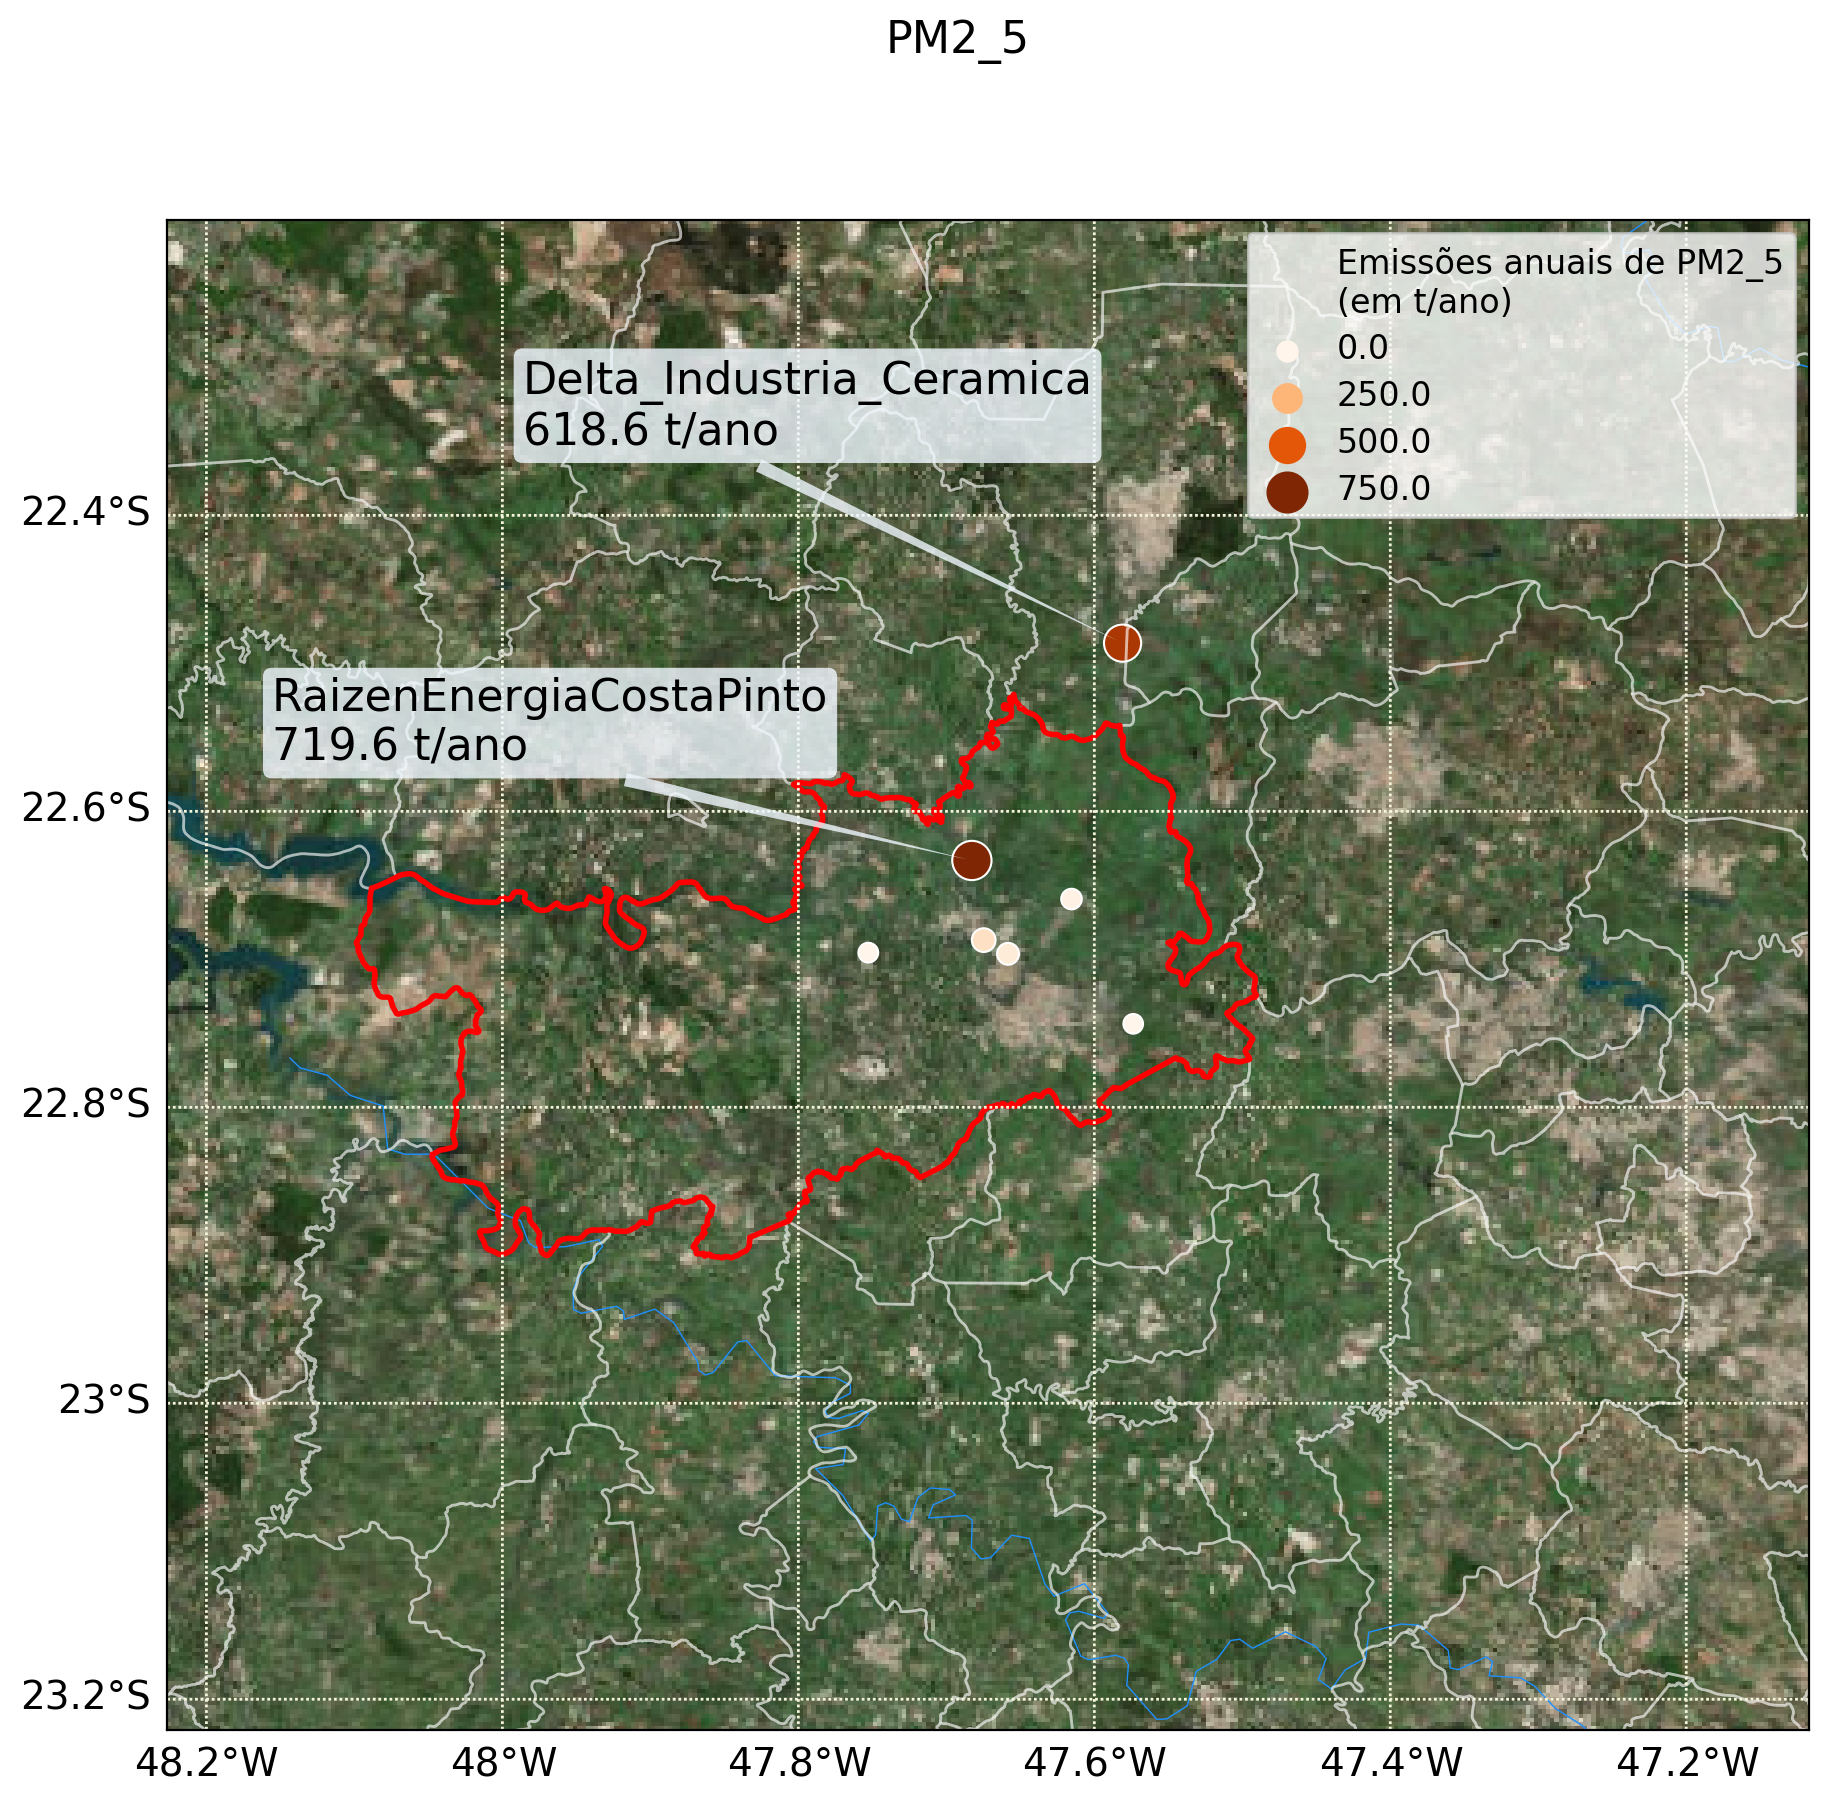

In [19]:
pollut = 'PM2_5'
pollutplt = emis[emis.index.get_level_values('cas').isin([pollut])]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,10), dpi=200)
b = 3

#box boundary 
bot_left_lat  = np.min(wrflats[b])
bot_left_lon  = np.min(wrflong[b])
top_right_lat = np.max(wrflats[b])
top_right_lon = np.max(wrflong[b])
center_lat    = np.mean(wrflats[b])
center_long   = np.mean(wrflong[b])

m = Basemap(epsg=4326, 
              llcrnrlon=bot_left_lon, 
              llcrnrlat=bot_left_lat,
              urcrnrlon=top_right_lon,
              urcrnrlat=top_right_lat,
              resolution='h',
              projection='lambert',
              ellps='WGS84',
              lat_0=center_lat,
              lon_0=center_long,
              ax = ax)

# ADD FEATURES
# Draw some map elements on the map
#m.drawcoastlines(linewidth=1.0, color='w', zorder=1)
#m.drawstates(linewidth=1.0, color='w', zorder=1)
#m.drawcountries(linewidth=1.0, color='w', zorder=1)
m.bluemarble()
#m.shadedrelief()
m.drawrivers(color='dodgerblue')
m.drawparallels(np.arange(-80., 81., 0.2), color='beige', labels=[1,0,0,0], fontsize=14)       
m.drawmeridians(np.arange(-180., 181., 0.2), color='beige', labels=[0,0,0,1], fontsize=14)

# ADD BACKGROUND
maps = ['ESRI_Imagery_World_2D',    # 0
        'ESRI_StreetMap_World_2D',  # 1
        'NatGeo_World_Map',         # 2
        'NGS_Topo_US_2D',           # 3
        'Ocean_Basemap',            # 4
        'USA_Topo_Maps',            # 5
        'World_Imagery',            # 6
        'World_Physical_Map',       # 7
        'World_Shaded_Relief',      # 8
        'World_Street_Map',         # 9
        'World_Terrain_Base',       # 10
        'World_Topo_Map'            # 11
        ]
m.arcgisimage(service=maps[6], dpi=1000, verbose= True)

# ADD SHAPES
shps = ['Piracicaba']
colors= {'Piracicaba':'red'}
shapes = {}
m.readshapefile(metdir+'arqShape/BRMUE250GC_SIR', 'Municipios', color=(1,1,1,0.4), linewidth=1.0)

m.readshapefile(metdir+'arqShape/pirashape', 'Piracicaba', drawbounds = True, color='r', linewidth=2.0)

emi_plt = sns.scatterplot(x=pollutplt['xloc'],y=pollutplt['yloc'], 
                size=pollutplt['ann_emis'],hue=pollutplt['ann_emis'],
                data=pollutplt, 
                palette='Oranges',
                sizes=(50,200),
                ax=ax)
legend = ax.legend()
legend.texts[0].set_text('Emissões anuais de '+pollutplt.index[0][1]+'\n(em t/ano)')
#legend.set_title(True)
legend.prop.set_size('large')
legend.set_frame_on(True)

#ANNOTATE OS 2 MAIORES!
bbox_args=dict(pad=0.2,boxstyle="round", fc='aliceblue', ec="none", alpha=0.8)
arrow_args=dict(arrowstyle='wedge',relpos=(0.2, 0.5),
                fc='aliceblue', ec="none", alpha=0.8)

dx=[-700,-600]
dy=[100,200]
i=0
for row in pollutplt.sort_values(by='ann_emis',ascending=False).head(2).iterrows():
    ax.annotate(row[0][0]+'\n'+str(round(row[1]['ann_emis'],1))+' t/ano',
               xy=(row[1]['xloc'],row[1]['yloc']),
               xycoords='data',
               xytext=(dx[i],dy[i]),
               textcoords='offset pixels',
               fontsize=16, color='k',
               bbox=bbox_args,
               arrowprops=arrow_args,
               zorder=10)
    i+=1
fig.suptitle(pollut, fontsize=16)
plt.show()

http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=-48.2264404296875,-23.22050476074219,-47.117279052734375,-22.200126647949222&bboxSR=4326&imageSR=4326&size=400,367&dpi=1000&format=png32&f=image


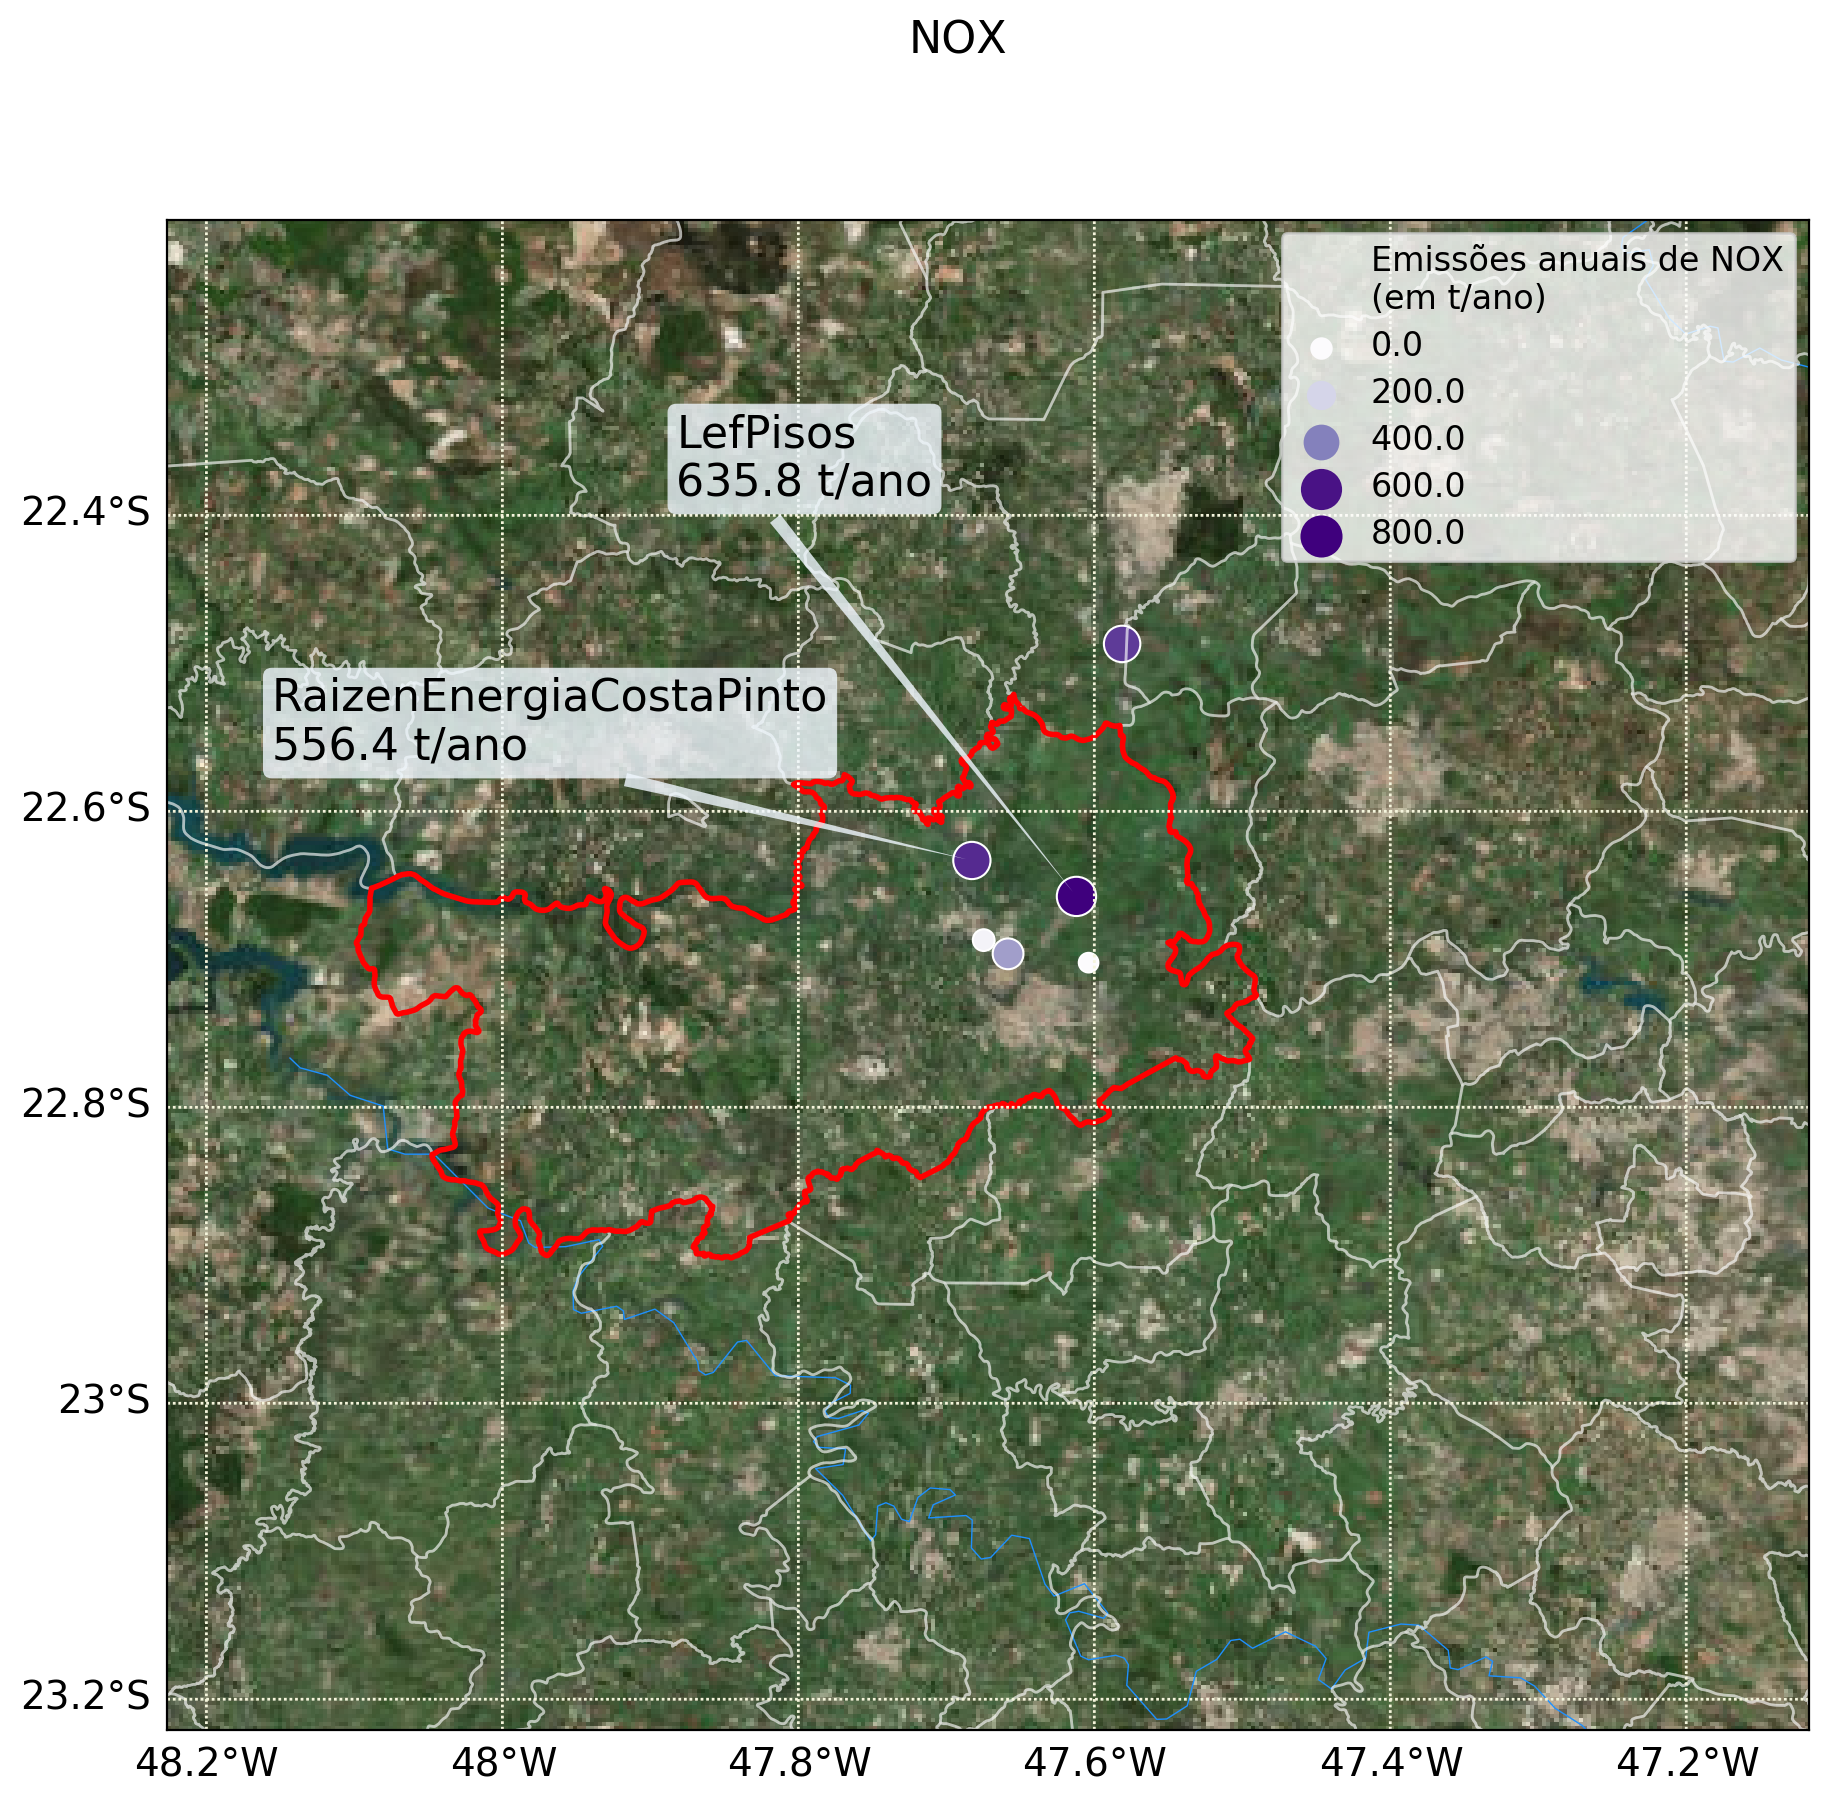

In [23]:
pollut = 'NOX'
pollutplt = emis[emis.index.get_level_values('cas').isin([pollut])]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,10), dpi=200)
b = 3
#box boundary 
bot_left_lat  = np.min(wrflats[b])
bot_left_lon  = np.min(wrflong[b])
top_right_lat = np.max(wrflats[b])
top_right_lon = np.max(wrflong[b])
center_lat    = np.mean(wrflats[b])
center_long   = np.mean(wrflong[b])
#PLOTMAP
m = Basemap(epsg=4326, 
              llcrnrlon=bot_left_lon, 
              llcrnrlat=bot_left_lat,
              urcrnrlon=top_right_lon,
              urcrnrlat=top_right_lat,
              resolution='h',
              projection='lambert',
              ellps='WGS84',
              lat_0=center_lat,
              lon_0=center_long,
              ax = ax)
# ADD FEATURES
# Draw some map elements on the map
#m.drawcoastlines(linewidth=1.0, color='w', zorder=1)
#m.drawstates(linewidth=1.0, color='w', zorder=1)
#m.drawcountries(linewidth=1.0, color='w', zorder=1)
m.bluemarble()
#m.shadedrelief()
m.drawrivers(color='dodgerblue')
m.drawparallels(np.arange(-80., 81., 0.2), color='beige', labels=[1,0,0,0], fontsize=14)       
m.drawmeridians(np.arange(-180., 181., 0.2), color='beige', labels=[0,0,0,1], fontsize=14)

# ADD BACKGROUND
maps = ['ESRI_Imagery_World_2D',    # 0
        'ESRI_StreetMap_World_2D',  # 1
        'NatGeo_World_Map',         # 2
        'NGS_Topo_US_2D',           # 3
        'Ocean_Basemap',            # 4
        'USA_Topo_Maps',            # 5
        'World_Imagery',            # 6
        'World_Physical_Map',       # 7
        'World_Shaded_Relief',      # 8
        'World_Street_Map',         # 9
        'World_Terrain_Base',       # 10
        'World_Topo_Map'            # 11
        ]
m.arcgisimage(service=maps[6], dpi=1000, verbose= True)

# ADD SHAPES
shps = ['Piracicaba']
colors= {'Piracicaba':'red'}
shapes = {}
m.readshapefile(metdir+'arqShape/BRMUE250GC_SIR', 'Municipios', color=(1,1,1,0.4), linewidth=1.0)

m.readshapefile(metdir+'arqShape/pirashape', 'Piracicaba', drawbounds = True, color='r', linewidth=2.0)

emi_plt = sns.scatterplot(x=pollutplt['xloc'],y=pollutplt['yloc'], 
                size=pollutplt['ann_emis'],hue=pollutplt['ann_emis'],
                data=pollutplt, 
                palette='Purples',
                sizes=(50,200),
                ax=ax)
legend = ax.legend()
legend.texts[0].set_text('Emissões anuais de '+pollutplt.index[0][1]+'\n(em t/ano)')
legend.prop.set_size('large')
#legend.set_title(True)
legend.set_frame_on(True)

#ANNOTATE OS 2 MAIORES!
bbox_args=dict(pad=0.2,boxstyle="round", fc='aliceblue', ec="none", alpha=0.8)
arrow_args=dict(arrowstyle='wedge',relpos=(0.2, 0.5),
                fc='aliceblue', ec="none", alpha=0.8)

dx=[-400,-700]
dy=[400,100]
i=0
for row in pollutplt.sort_values(by='ann_emis',ascending=False).head(2).iterrows():
    ax.annotate(row[0][0]+'\n'+str(round(row[1]['ann_emis'],1))+' t/ano',
               xy=(row[1]['xloc'],row[1]['yloc']),
               xycoords='data',
               xytext=(dx[i],dy[i]),
               textcoords='offset pixels',
               fontsize=16, color='k',
               bbox=bbox_args,
               arrowprops=arrow_args,
               zorder=10)
    i+=1
fig.suptitle(pollut, fontsize=16)
plt.show()

http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=-48.2264404296875,-23.22050476074219,-47.117279052734375,-22.200126647949222&bboxSR=4326&imageSR=4326&size=400,367&dpi=1000&format=png32&f=image


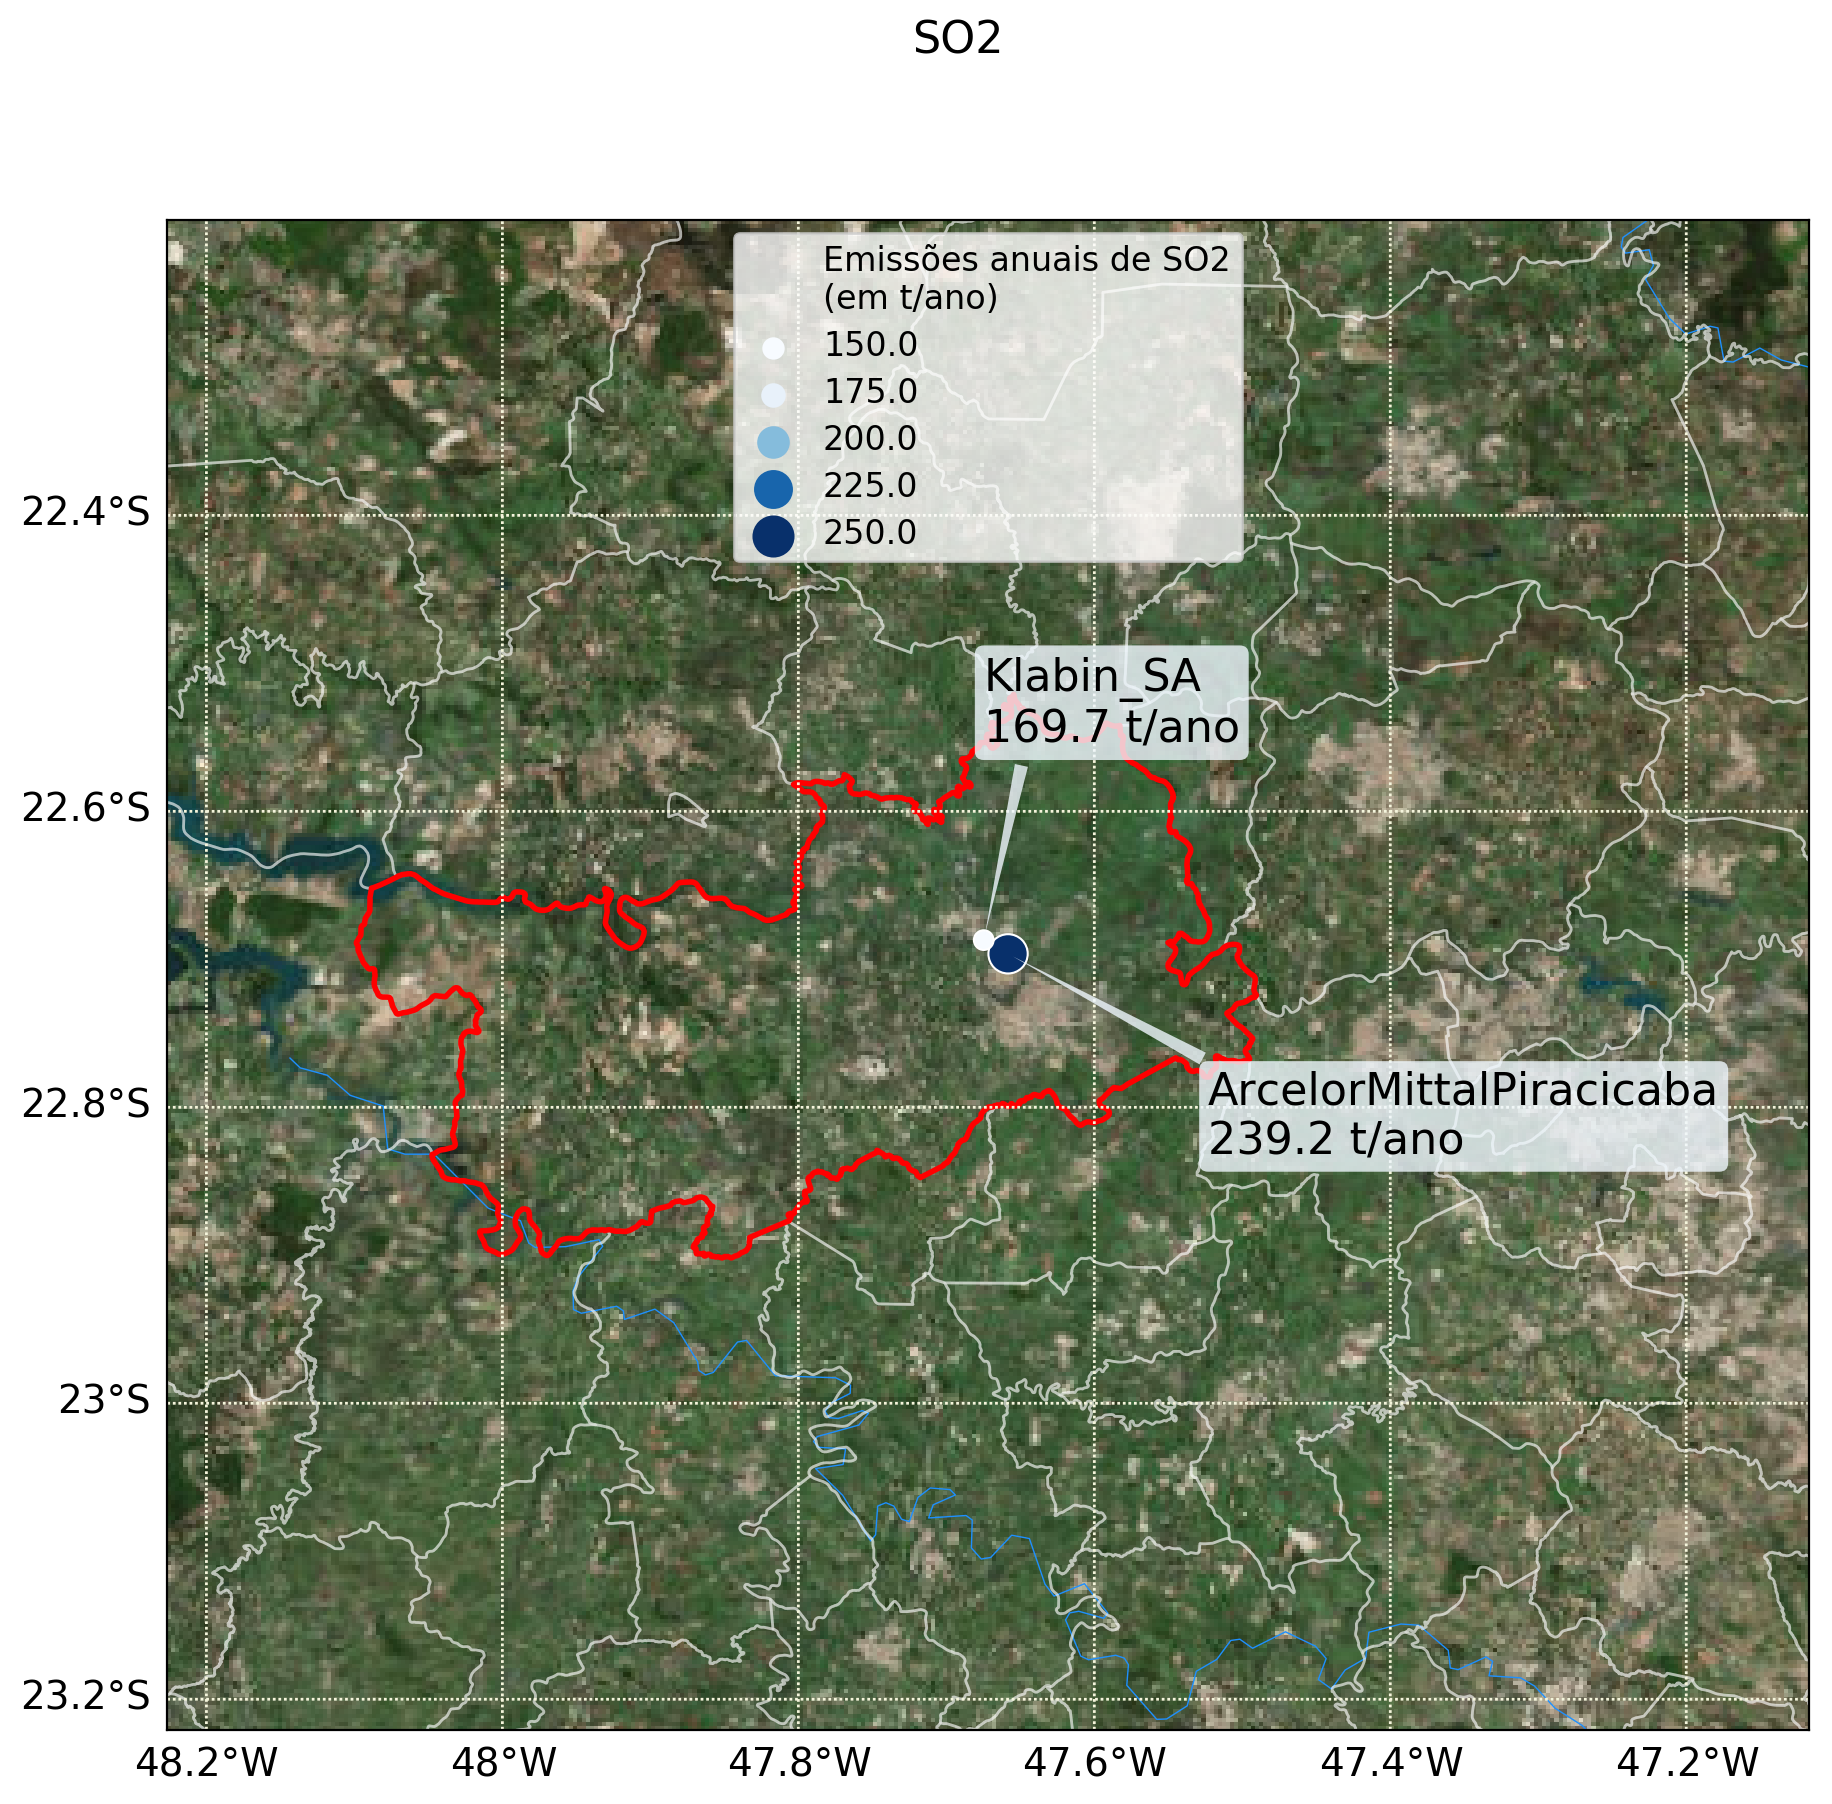

In [24]:
pollut = 'SO2'
pollutplt = emis[emis.index.get_level_values('cas').isin([pollut])]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,10), dpi=200)
b = 3
#box boundary 
bot_left_lat  = np.min(wrflats[b])
bot_left_lon  = np.min(wrflong[b])
top_right_lat = np.max(wrflats[b])
top_right_lon = np.max(wrflong[b])
center_lat    = np.mean(wrflats[b])
center_long   = np.mean(wrflong[b])
#PLOTMAP
m = Basemap(epsg=4326, 
              llcrnrlon=bot_left_lon, 
              llcrnrlat=bot_left_lat,
              urcrnrlon=top_right_lon,
              urcrnrlat=top_right_lat,
              resolution='h',
              projection='lambert',
              ellps='WGS84',
              lat_0=center_lat,
              lon_0=center_long,
              ax = ax)
# ADD FEATURES
# Draw some map elements on the map
#m.drawcoastlines(linewidth=1.0, color='w', zorder=1)
#m.drawstates(linewidth=1.0, color='w', zorder=1)
#m.drawcountries(linewidth=1.0, color='w', zorder=1)
m.bluemarble()
#m.shadedrelief()
m.drawrivers(color='dodgerblue')
m.drawparallels(np.arange(-80., 81., 0.2), color='beige', labels=[1,0,0,0], fontsize=14)       
m.drawmeridians(np.arange(-180., 181., 0.2), color='beige', labels=[0,0,0,1], fontsize=14)

# ADD BACKGROUND
maps = ['ESRI_Imagery_World_2D',    # 0
        'ESRI_StreetMap_World_2D',  # 1
        'NatGeo_World_Map',         # 2
        'NGS_Topo_US_2D',           # 3
        'Ocean_Basemap',            # 4
        'USA_Topo_Maps',            # 5
        'World_Imagery',            # 6
        'World_Physical_Map',       # 7
        'World_Shaded_Relief',      # 8
        'World_Street_Map',         # 9
        'World_Terrain_Base',       # 10
        'World_Topo_Map'            # 11
        ]
m.arcgisimage(service=maps[6], dpi=1000, verbose= True)

# ADD SHAPES
shps = ['Piracicaba']
colors= {'Piracicaba':'red'}
shapes = {}
m.readshapefile(metdir+'arqShape/BRMUE250GC_SIR', 'Municipios', color=(1,1,1,0.4), linewidth=1.0)

m.readshapefile(metdir+'arqShape/pirashape', 'Piracicaba', drawbounds = True, color='r', linewidth=2.0)

emi_plt = sns.scatterplot(x=pollutplt['xloc'],y=pollutplt['yloc'], 
                size=pollutplt['ann_emis'],hue=pollutplt['ann_emis'],
                data=pollutplt, 
                palette='Blues',
                sizes=(50,200),
                ax=ax)
legend = ax.legend()
legend.texts[0].set_text('Emissões anuais de '+pollutplt.index[0][1]+'\n(em t/ano)')
legend.prop.set_size('large')
#legend.set_title(True)
legend.set_frame_on(True)

#ANNOTATE OS 2 MAIORES!
bbox_args=dict(pad=0.2,boxstyle="round", fc='aliceblue', ec="none", alpha=0.8)
arrow_args=dict(arrowstyle='wedge',relpos=(0.2, 0.5),
                fc='aliceblue', ec="none", alpha=0.8)

dx=[200,0]
dy=[-200,200]
i=0
for row in pollutplt.sort_values(by='ann_emis',ascending=False).head(2).iterrows():
    ax.annotate(row[0][0]+'\n'+str(round(row[1]['ann_emis'],1))+' t/ano',
               xy=(row[1]['xloc'],row[1]['yloc']),
               xycoords='data',
               xytext=(dx[i],dy[i]),
               textcoords='offset pixels',
               fontsize=16, color='k',
               bbox=bbox_args,
               arrowprops=arrow_args,
               zorder=10)
    i+=1
fig.suptitle(pollut, fontsize=16)
plt.show()

http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=-48.2264404296875,-23.22050476074219,-47.117279052734375,-22.200126647949222&bboxSR=4326&imageSR=4326&size=400,367&dpi=1000&format=png32&f=image


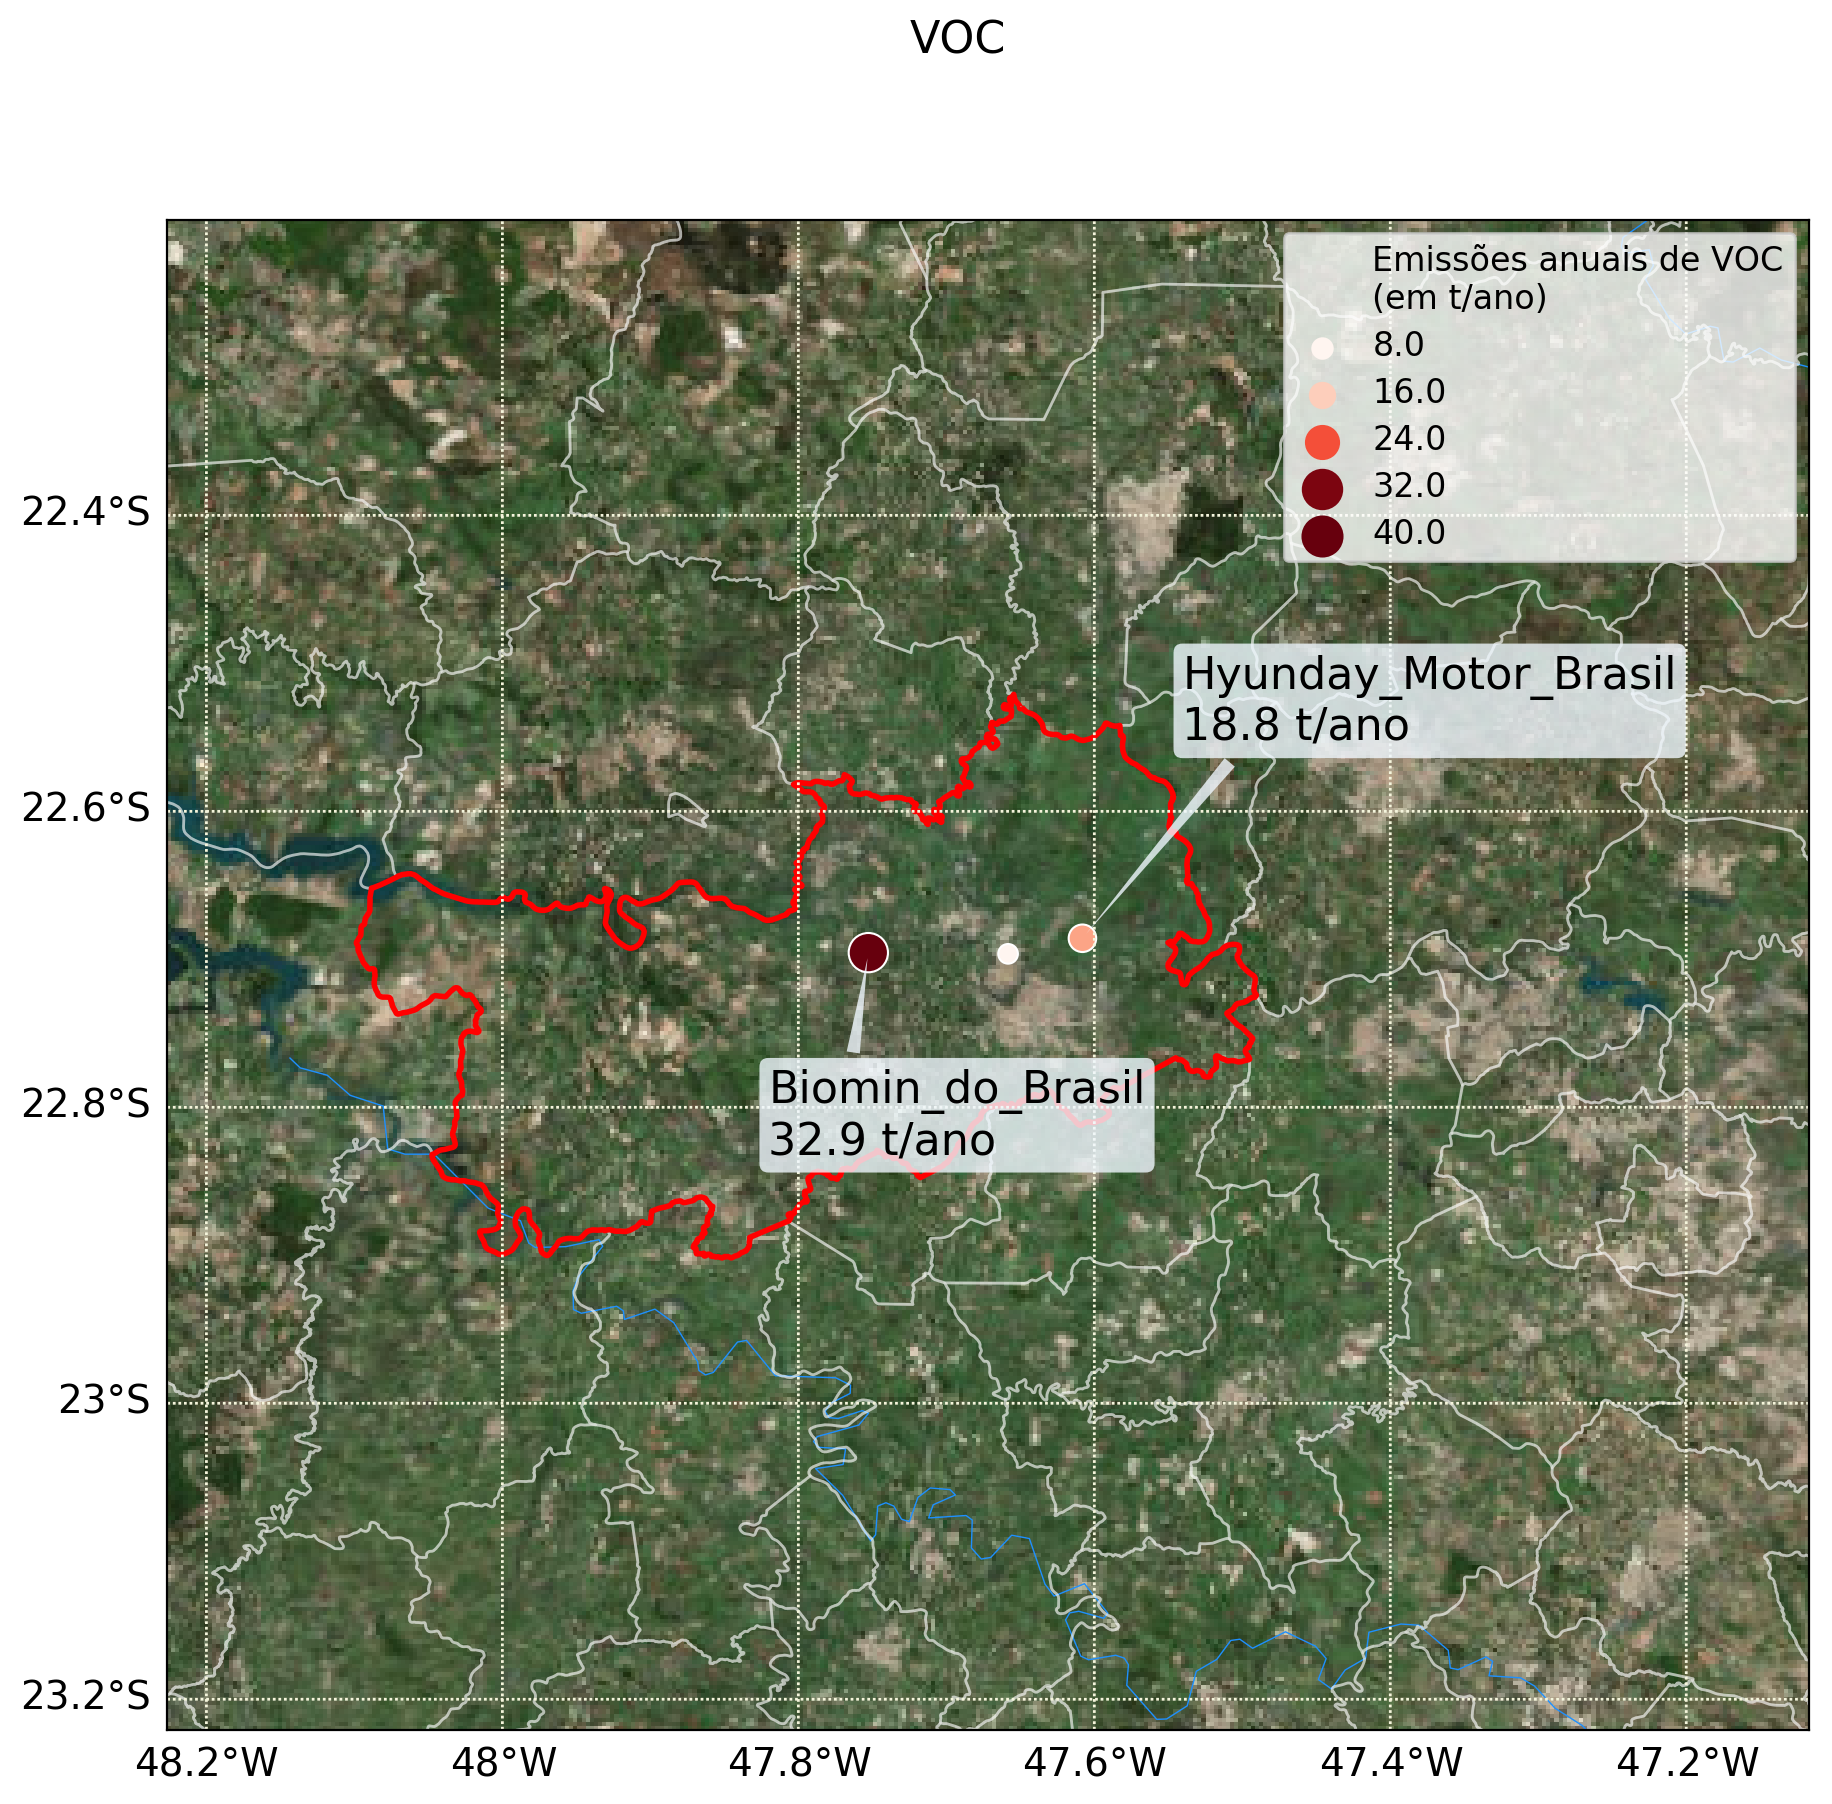

In [25]:
pollut = 'VOC'
pollutplt = emis[emis.index.get_level_values('cas').isin([pollut])]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,10), dpi=200)
b = 3
#box boundary 
bot_left_lat  = np.min(wrflats[b])
bot_left_lon  = np.min(wrflong[b])
top_right_lat = np.max(wrflats[b])
top_right_lon = np.max(wrflong[b])
center_lat    = np.mean(wrflats[b])
center_long   = np.mean(wrflong[b])
#PLOTMAP
m = Basemap(epsg=4326, 
              llcrnrlon=bot_left_lon, 
              llcrnrlat=bot_left_lat,
              urcrnrlon=top_right_lon,
              urcrnrlat=top_right_lat,
              resolution='h',
              projection='lambert',
              ellps='WGS84',
              lat_0=center_lat,
              lon_0=center_long,
              ax = ax)
# ADD FEATURES
# Draw some map elements on the map
#m.drawcoastlines(linewidth=1.0, color='w', zorder=1)
#m.drawstates(linewidth=1.0, color='w', zorder=1)
#m.drawcountries(linewidth=1.0, color='w', zorder=1)
m.bluemarble()
#m.shadedrelief()
m.drawrivers(color='dodgerblue')
m.drawparallels(np.arange(-80., 81., 0.2), color='beige', labels=[1,0,0,0], fontsize=14)       
m.drawmeridians(np.arange(-180., 181., 0.2), color='beige', labels=[0,0,0,1], fontsize=14)

# ADD BACKGROUND
maps = ['ESRI_Imagery_World_2D',    # 0
        'ESRI_StreetMap_World_2D',  # 1
        'NatGeo_World_Map',         # 2
        'NGS_Topo_US_2D',           # 3
        'Ocean_Basemap',            # 4
        'USA_Topo_Maps',            # 5
        'World_Imagery',            # 6
        'World_Physical_Map',       # 7
        'World_Shaded_Relief',      # 8
        'World_Street_Map',         # 9
        'World_Terrain_Base',       # 10
        'World_Topo_Map'            # 11
        ]
m.arcgisimage(service=maps[6], dpi=1000, verbose= True)

# ADD SHAPES
shps = ['Piracicaba']
colors= {'Piracicaba':'red'}
shapes = {}
m.readshapefile(metdir+'arqShape/BRMUE250GC_SIR', 'Municipios', color=(1,1,1,0.4), linewidth=1.0)

m.readshapefile(metdir+'arqShape/pirashape', 'Piracicaba', drawbounds = True, color='r', linewidth=2.0)

emi_plt = sns.scatterplot(x=pollutplt['xloc'],y=pollutplt['yloc'], 
                size=pollutplt['ann_emis'],hue=pollutplt['ann_emis'],
                data=pollutplt, 
                palette='Reds',
                sizes=(50,200),
                ax=ax)
legend = ax.legend()
legend.texts[0].set_text('Emissões anuais de '+pollutplt.index[0][1]+'\n(em t/ano)')
legend.prop.set_size('large')
#legend.set_title(True)
legend.set_frame_on(True)

#ANNOTATE OS 2 MAIORES!
bbox_args=dict(pad=0.2,boxstyle="round", fc='aliceblue', ec="none", alpha=0.8)
arrow_args=dict(arrowstyle='wedge',relpos=(0.2, 0.5),
                fc='aliceblue', ec="none", alpha=0.8)

dx=[-100,100]
dy=[-200,200]
i=0
for row in pollutplt.sort_values(by='ann_emis',ascending=False).head(2).iterrows():
    ax.annotate(row[0][0]+'\n'+str(round(row[1]['ann_emis'],1))+' t/ano',
               xy=(row[1]['xloc'],row[1]['yloc']),
               xycoords='data',
               xytext=(dx[i],dy[i]),
               textcoords='offset pixels',
               fontsize=16, color='k',
               bbox=bbox_args,
               arrowprops=arrow_args,
               zorder=10)
    i+=1
fig.suptitle(pollut, fontsize=16)
plt.show()